# Model Builder
---

## Imports


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

### Data

In [15]:
train_path = '../pickles/train_modified_1.pkl'
test_path = '../pickles/test_modified_1.pkl'

with open(train_path, 'rb') as f:
    train_full = pickle.load(f)

with open(test_path, 'rb') as f:
    test_full = pickle.load(f)


In [16]:
train_full.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,group,...,6,7,8,9,10,11,12,13,14,15
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,False,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,True,2,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,True,4,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [17]:
test_full.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,group,group_num,...,6,7,8,9,10,11,12,13,14,15
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,13,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,18,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,19,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,21,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,23,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


#### Train Test Split

In [18]:
y = train_full['Transported']
X = train_full.drop(columns=['Transported'], axis=1)

In [19]:
X.shape, y.shape

((8693, 34), (8693,))

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Build

Initial test with baseline model

In [21]:
model = RandomForestClassifier(random_state=42)

### Parameter Tuning

Found parameter distributions from this stack overflow link: [StackOverFlow](https://stackoverflow.com/questions/53782169/random-forest-tuning-with-randomizedsearchcv)

In [34]:
param_dist = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [5000]}

In [35]:
rand_search = RandomizedSearchCV(model, param_dist, n_iter= 5, cv= 5, random_state=42)

In [36]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [5000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=42)

In [37]:
model = rand_search.best_estimator_

In [38]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_samples=5000,
                       min_samples_leaf=np.int64(15),
                       min_samples_split=np.int64(14),
                       n_estimators=np.int64(40), random_state=42)

In [39]:
preds = model.predict(X_valid)

In [41]:
score = model.score(X_valid, y_valid) * 100
print(f"{score : .2f}")

 79.18


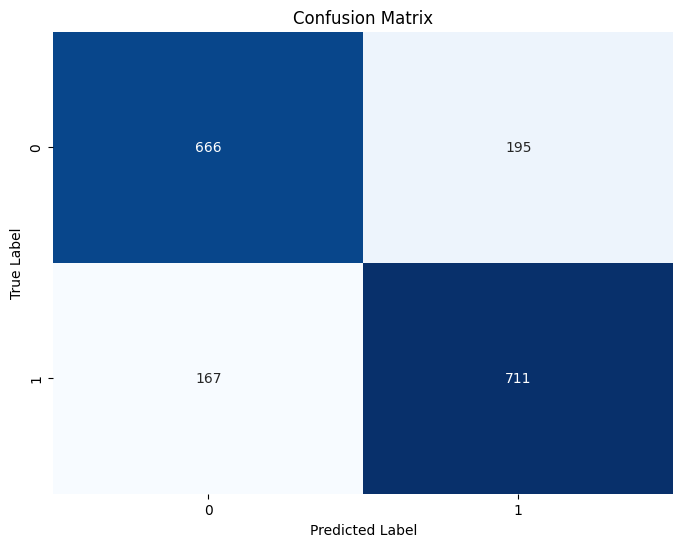

In [42]:
cm = confusion_matrix(y_valid,preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [53]:
final_model = rand_search.best_estimator_

final_model.fit(X, y)

RandomForestClassifier(max_depth=10, max_samples=5000,
                       min_samples_leaf=np.int64(15),
                       min_samples_split=np.int64(14),
                       n_estimators=np.int64(40), random_state=42)

## Export

In [54]:
from datetime import datetime
import pytz

In [55]:
predictions = final_model.predict(test_full)

In [56]:
df_dummy = pd.read_csv('../data/test.csv')

In [57]:
final = pd.DataFrame()
final['PassengerId'] = df_dummy['PassengerId']
final['Transported'] = predictions

In [58]:
date_time = datetime.now(tz=pytz.timezone('US/Eastern')).strftime("%Y_%m_%d-%H_%M_%S_%p")
file_path = f'../submission-csv/submission_{date_time}.csv'
final.to_csv(file_path, index = False)